In [1]:
from common import *
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from WholeBrain.Utils.p_values import plotComparisonAcrossLabels2
from WholeBrain.Observables.event_based_intrinsic_ignition import EventBasedIntrinsicIgnition
from WholeBrain.Filters.bold_band_pass_filter import BOLDBandPassFilter

************************* Subjects Info *************************
ID              FMRI_TR (ms)    TYPE                           VOLUME (cm³)    # REGIONS WITH TUMOR
sub-CON01       2100.0          none                           0.0             0              
sub-CON02       2100.0          none                           0.0             0              
sub-CON03       2100.0          none                           0.0             0              
sub-CON04       2100.0          none                           0.0             0              
sub-CON05       2400.0          none                           0.0             0              
sub-CON06       2400.0          none                           0.0             0              
sub-CON07       2400.0          none                           0.0             0              
sub-CON08       2400.0          none                           0.0             0              
sub-CON09       2400.0          none                           0.0        

In [2]:
control_subset = subjects.get_control_subset()
tumor_subset = subjects.get_tumor_subset()

Let's compute ignition for all subjects

In [3]:
preop_ts_dk68 = subjects.filter_preop_ts_dk68()
ignitions = dict()

for sub_id, ts_dk68 in preop_ts_dk68.items():

    tr_ms = subjects.get_subject_by_id(sub_id).get_fmri_tr()

    # If we use length 8 for the 2100ms TR scans and length 7 for the 2400ms scans (or multiple of them), then we have the same windows
    # time frame for each subject (16800ms)
    ignition_tr_length = None
    if np.isclose(tr_ms, 2400.0):
        ignition_tr_length = 7
    elif np.isclose(tr_ms, 2100.0):
        ignition_tr_length = 8
    assert ignition_tr_length is not None, "Ups... TR length not 2100 or 2400..."

    ebig_operator = EventBasedIntrinsicIgnition(ignition_tr_length=ignition_tr_length)

    ebig_dk68 = ebig_operator.from_fMRI(
        ts_dk68,
        # flp=0.01, fhi=0.1
        #   Tagliazucchi, Enzo, Pablo Balenzuela, Daniel Fraiman, and Dante R. Chialvo.
        #       “Criticality in Large-Scale Brain FMRI Dynamics Unveiled by a Novel
        #       Point Process Analysis.” Frontiers in Physiology 3 (2012). https://doi.org/10.3389/fphys.2012.00015.
        #
        # flp=0.04, fhi=0.07. NOTE: This paper uses phased based intrinsic ignition.
        #   Glerean, Enrico, Juha Salmi, Juha M. Lahnakoski, Iiro P. Jääskeläinen, and Mikko Sams.
        #       “Functional Magnetic Resonance Imaging Phase Synchronization as a Measure of Dynamic Functional Connectivity.”
        #       Brain Connectivity 2, no. 2 (April 2012): 91–101. https://doi.org/10.1089/brain.2011.0068.

        # Anira paper flp=0.01 fhi=0.09
        BOLD_filter=BOLDBandPassFilter(tr=tr_ms/1000.0, flp=0.01, fhi=0.09, k=2, remove_strong_artifacts=3.0)
    )
    ignitions[sub_id] = ebig_dk68

Now we plot ignition parameters (mean ignition, std ignition and fan factor) binning between tumor / non-tumor regions

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Tumor regions vs. Non Tumor Regions: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:3.161e-02 U_stat=8.777e+04


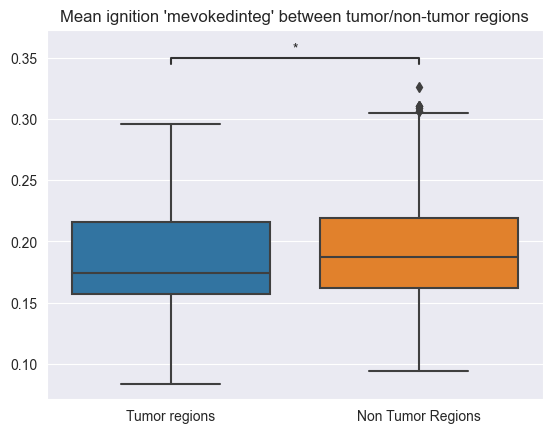

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Tumor regions vs. Non Tumor Regions: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:4.228e-02 U_stat=8.839e+04


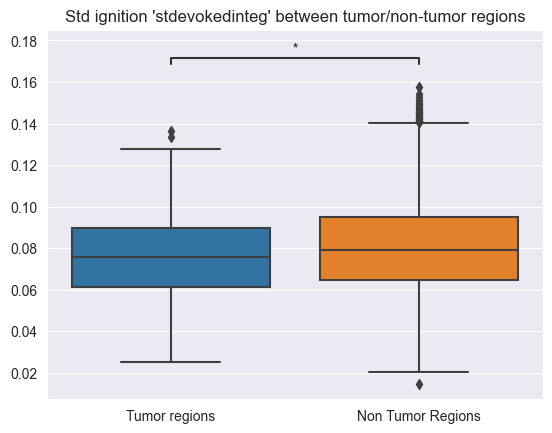

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Tumor regions vs. Non Tumor Regions: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.457e-01 U_stat=9.145e+04


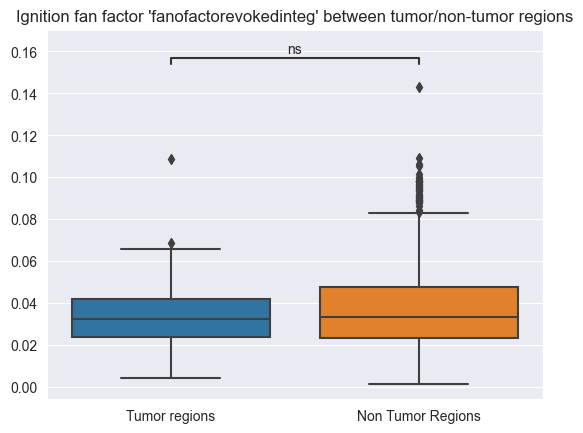

In [4]:
tumor_region_mean_ignition = []
non_tumor_region_mean_ignition = []
tumor_region_std_ignition = []
non_tumor_region_std_ignition = []
tumor_region_fanfact_ignition = []
non_tumor_region_fanfact_ignition = []

for k, s in tumor_subset.items():
    for i in range(68):
        if s.tumor_regions.is_tumor_region_by_id(i):
            tumor_region_mean_ignition.append(ignitions[k].mevokedinteg[i])
            tumor_region_std_ignition.append(ignitions[k].stdevokedinteg[i])
            tumor_region_fanfact_ignition.append(ignitions[k].fanofactorevokedinteg[i])
        else:
            non_tumor_region_mean_ignition.append(ignitions[k].mevokedinteg[i])
            non_tumor_region_std_ignition.append(ignitions[k].stdevokedinteg[i])
            non_tumor_region_fanfact_ignition.append(ignitions[k].fanofactorevokedinteg[i])

plotComparisonAcrossLabels2(
    {
        'Tumor regions': tumor_region_mean_ignition,
        'Non Tumor Regions': non_tumor_region_mean_ignition,
    },
    graphLabel="Mean ignition 'mevokedinteg' between tumor/non-tumor regions"
)

plotComparisonAcrossLabels2(
    {
        'Tumor regions': tumor_region_std_ignition,
        'Non Tumor Regions': non_tumor_region_std_ignition,
    },
    graphLabel="Std ignition 'stdevokedinteg' between tumor/non-tumor regions"
)

plotComparisonAcrossLabels2(
    {
        'Tumor regions': tumor_region_fanfact_ignition,
        'Non Tumor Regions': non_tumor_region_fanfact_ignition,
    },
    graphLabel="Ignition fan factor 'fanofactorevokedinteg' between tumor/non-tumor regions"
)

Before calculating the mean ignition, let's plot controls dispersion for each region. We seperate between left and right hemisphere for better readability.

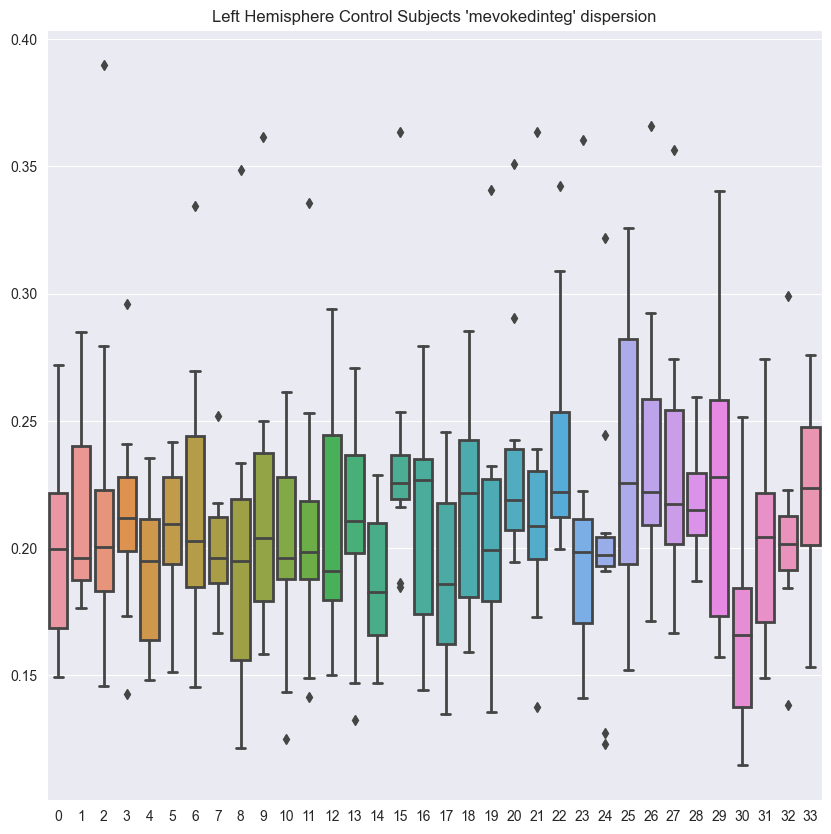

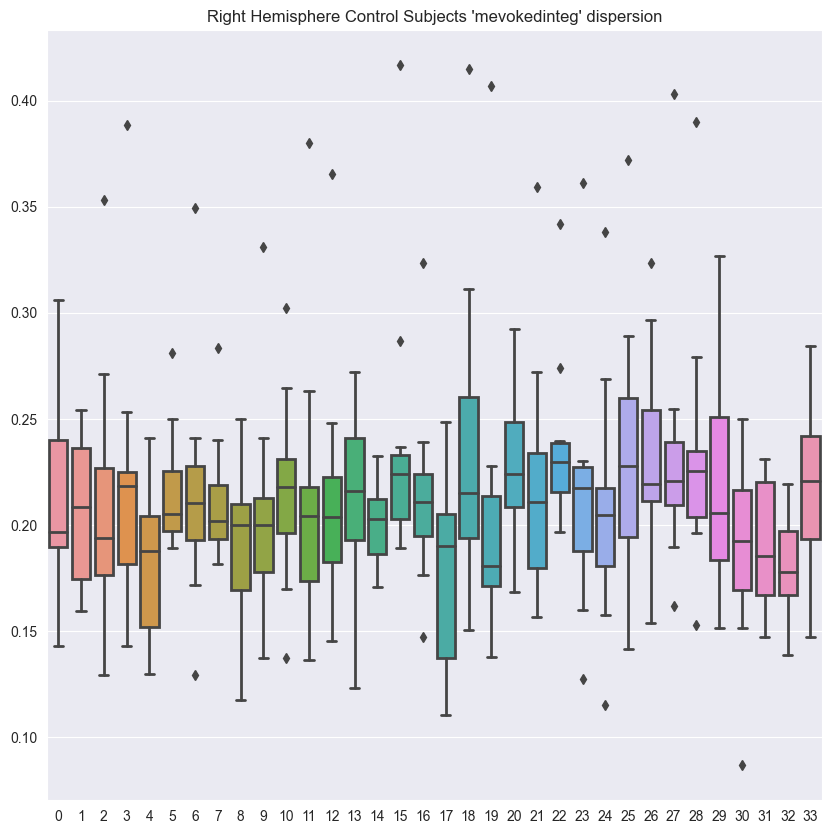

In [5]:
plt.figure(figsize=(10, 10))
seaborn.boxplot(
    data=pd.Series(
        data={str(i): [ignitions[k].mevokedinteg[i] for k, sub in control_subset.items()] for i in range(34)}
    ),
    linewidth=2.0
)
plt.title("Left Hemisphere Control Subjects 'mevokedinteg' dispersion")
plt.show()

plt.figure(figsize=(10, 10))
seaborn.boxplot(
    data=pd.Series(
        data={str(i): [ignitions[k].mevokedinteg[i] for k, sub in control_subset.items()] for i in range(34, 68)},
    ),
    linewidth=2.0
)
plt.title("Right Hemisphere Control Subjects 'mevokedinteg' dispersion")
plt.show()

Out of curiosity, let's see how different is control subjects 'mevokedinteg' between hemispheres...

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Left vs. Right: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:9.358e-01 U_stat=6.970e+04


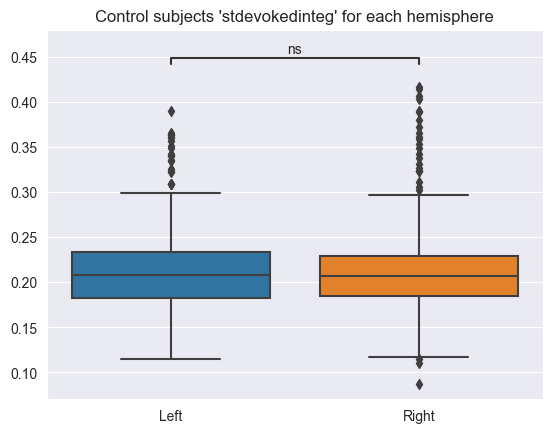

In [6]:
plotComparisonAcrossLabels2(
    {
        'Left': [ignitions[k].mevokedinteg[i] for k, _ in control_subset.items() for i in range(34)],
        'Right': [ignitions[k].mevokedinteg[i] for k, _ in control_subset.items() for i in range(34, 68)],
    },
    graphLabel="Control subjects 'stdevokedinteg' for each hemisphere"
)

Now let's compute the mean ignition between control subjects

In [7]:
mean_control_ignition = [{
    'mevokedinteg': 0.0,
    'stdevokedinteg': 0.0,
    'fanofactorevokedinteg': 0.0,
} for i in range(68)]

for k, sub in control_subset.items():
    for i in range(68):
        mean_control_ignition[i]['mevokedinteg'] += ignitions[k].mevokedinteg[i]
        mean_control_ignition[i]['stdevokedinteg'] += ignitions[k].stdevokedinteg[i]
        mean_control_ignition[i]['fanofactorevokedinteg'] += ignitions[k].fanofactorevokedinteg[i]

for i in range(68):
    mean_control_ignition[i]['mevokedinteg'] /= control_subset.count()
    mean_control_ignition[i]['stdevokedinteg'] /= control_subset.count()
    mean_control_ignition[i]['fanofactorevokedinteg'] /= control_subset.count()

Compute delta ignition between patients and mean control

In [8]:
tumor_subjects_delta_ignitions = {}

for k, s in tumor_subset.items():
    tumor_subjects_delta_ignitions[k] = [{} for i in range(68)]
    for i in range(68):
        tumor_subjects_delta_ignitions[k][i]['mevokedinteg'] = ignitions[k].mevokedinteg[i] - mean_control_ignition[i]['mevokedinteg']
        tumor_subjects_delta_ignitions[k][i]['stdevokedinteg'] = ignitions[k].stdevokedinteg[i] - mean_control_ignition[i]['stdevokedinteg']
        tumor_subjects_delta_ignitions[k][i]['fanofactorevokedinteg'] = ignitions[k].fanofactorevokedinteg[i] - mean_control_ignition[i]['fanofactorevokedinteg']

Bin delta ignition for all patients between tumor and non-tumor regions

In [9]:
tumor_region_bin = []
non_tumor_region_bin = []

for k, s in tumor_subset.items():
    for i in range(68):
        if s.tumor_regions.is_tumor_region_by_id(i):
            tumor_region_bin.append(tumor_subjects_delta_ignitions[k][i])
        else:
            non_tumor_region_bin.append(tumor_subjects_delta_ignitions[k][i])

Let's plot this bins

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Tumor regions vs. Non Tumor Regions: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:7.820e-05 U_stat=7.822e+04


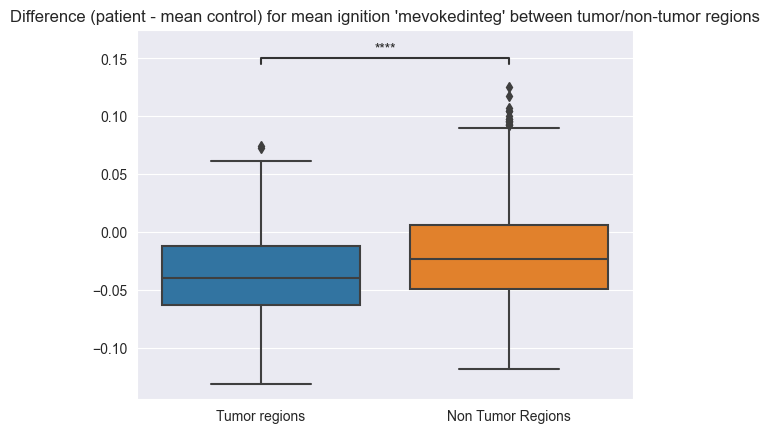

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Tumor regions vs. Non Tumor Regions: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:8.769e-03 U_stat=8.526e+04


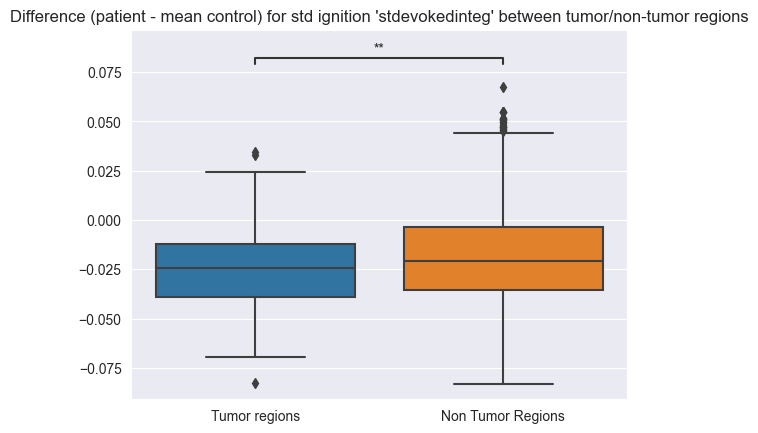

In [10]:
plotComparisonAcrossLabels2(
    {
        'Tumor regions': [r['mevokedinteg'] for r in tumor_region_bin],
        'Non Tumor Regions': [r['mevokedinteg'] for r in non_tumor_region_bin],
    },
    graphLabel="Difference (patient - mean control) for mean ignition 'mevokedinteg' between tumor/non-tumor regions"
)

plotComparisonAcrossLabels2(
    {
        'Tumor regions': [r['stdevokedinteg'] for r in tumor_region_bin],
        'Non Tumor Regions': [r['stdevokedinteg'] for r in non_tumor_region_bin],
    },
    graphLabel="Difference (patient - mean control) for std ignition 'stdevokedinteg' between tumor/non-tumor regions"
)

Let's visualize how delta 'mevokedinteg' is distributed between tumor/non-tumor regions from patients

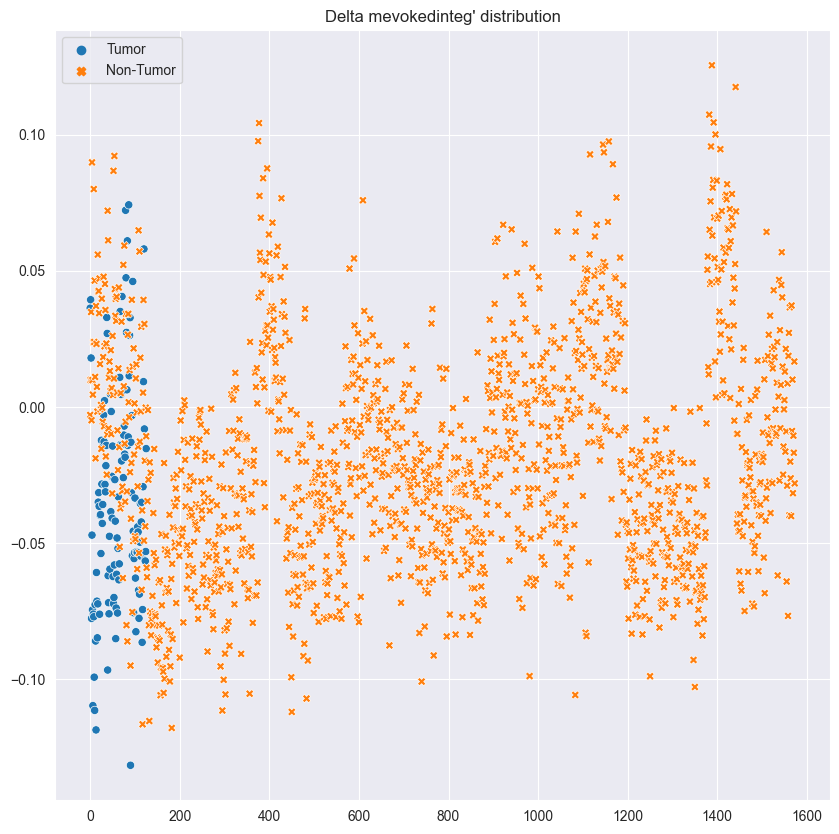

In [18]:
plt.figure(figsize=(10, 10))
seaborn.scatterplot(
    data={
        'Tumor': [r['mevokedinteg'] for r in tumor_region_bin],
        'Non-Tumor': [r['mevokedinteg'] for r in non_tumor_region_bin]
    }
)
plt.title("Delta mevokedinteg' distribution")
plt.show()

And delta 'mevokedinteg' by subject?

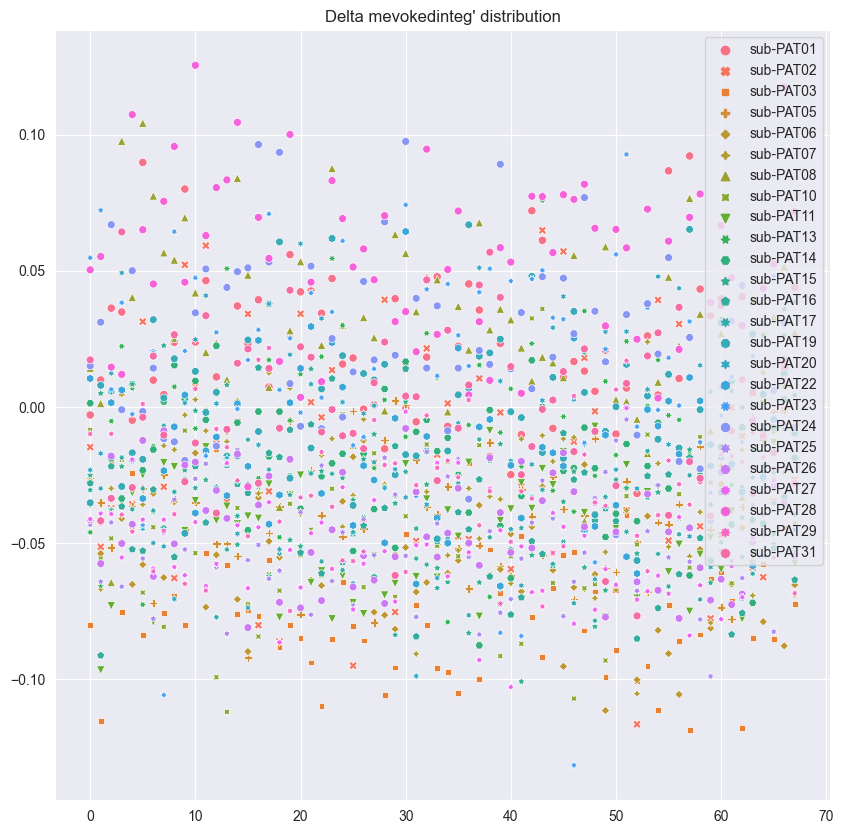

In [19]:
plt.figure(figsize=(10, 10))
seaborn.scatterplot(
    data={k: [v[i]['mevokedinteg'] for i in range(68)] for k, v in tumor_subjects_delta_ignitions.items()},
    x=
)
plt.title("Delta mevokedinteg' distribution")
plt.show()